# 단기강좌 실습 [Machine learning based seismic random noise attenuation]

본 실습에서는 머신러닝을 이용하여 중합 전 탄성파 자료에 대한 무작위 잡음 제거를 수행해본다.

잡음이 없는 인공 합성 자료와 현장에서 취득한 잡음 자료를 이용하여 구축된 학습 자료를 통해 학습을 수행하고 현장 자료에 적용한다.

실습 프로그램은 아래와 같이 구성되어 있다.

1. 학습 자료 및 테스트 자료 불러오기
2. 학습 자료 확인
3. DnCNN 인공 신경망 구성
4. 학습 모델 저장 및 불러오기
5. 모델 학습 수행
6. 학습된 모델을 테스트 자료에 적용 및 확인
7. 학습된 모델을 현장 탄성파 자료에 적용 (Denoise_apply.ipynb)

해당 실습 프로그램은 아래 논문에 기반하고 있다.

전형구, 김충호, 김한준, 2021, 잡음 자료 취득을 통한 기계학습 기반 현장 탄성파 자료 잡음 억제 연구, 한국자원공학회지, 58(5), 408-417, https://doi.org/10.32390/ksmer.2021.58.5.408

(패키지 환경)
pip install -r requirements.txt

In [1]:
import sys, gc, os
import numpy as np
import glob
from tensorflow.keras.optimizers import Adam
from keras import models, backend
from keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract
import re
from keras.models import Model, load_model
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm

epochs = 10
batch_size = 64
depth = 17
filters = 64
modeldir = 'model'
n_ch = 1

n1 = 400
n2 = 16
ndata = 1
ntest = 1

# 1. 학습 자료 및 테스트 자료 불러오기

In [2]:
def input_files(file_name):
    fin = open(file_name,"rb")
    patch = np.fromfile(fin,dtype='float32')
    fin.close()
    return patch

def load_train_data(data_dir,n1,n2,n_ch,datatype):
    ntrain = 0
    for idata in range(len(data_dir)):
        if idata == 0:
            file_list1 = glob.glob(data_dir[idata]+'addn_*') #get noise-added data
            file_list2 = glob.glob(data_dir[idata]+'free_*') #get noise-free  data
            print(len(file_list1))
            
    print('number of train data:',len(file_list1))
    file_list1 = sorted(file_list1)
    file_list2 = sorted(file_list2)
    
    if len(file_list1) != len(file_list2):
        print("ERROR: The number of shot and mask file is different")
        sys.exit(1)
    
    x_train = []
    y_train = []
    
    for ii in tqdm(range(len(file_list1))):
        patch1 = input_files(file_list1[ii])
        patch1 = list(patch1)
        
        patch2 = input_files(file_list2[ii])
        patch2 = list(patch2)
        
        x_train.append(patch1)
        y_train.append(patch2)
        
        ntrain = ntrain + 1
        
        del patch1
        del patch2
        
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_train = x_train.reshape(-1,n2,n1,n_ch)
    y_train = y_train.reshape(-1,n2,n1,n_ch)
    
    print("shape of train data:", x_train.shape,y_train.shape)
    print("ntrain: %d" %ntrain)
    return x_train, y_train                   
    

class DATA_read():
    def __init__(self, data_dir, test_dir, n_ch, n1, n2):
        print(data_dir,"n1:",n1,"n2:",n2)
        x_train, y_train = load_train_data(data_dir,n1,n2,n_ch,'train')
        x_test, y_test = load_train_data(test_dir,n1,n2,n_ch,'test')
        input_shape = (n2, n1, n_ch)
        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train, y_train
        self.x_test_in, self.x_test_out = x_test, y_test

In [3]:
data_dir = ['./data/train/']
test_dir = ['./data/test/']

data = DATA_read(data_dir=data_dir,test_dir=test_dir,n_ch=n_ch,n1=n1,n2=n2)
print(data.x_train_in.shape)
ntrain = data.x_train_in.shape[0]
ntest = data.x_test_in.shape[0]

['./data/train/'] n1: 400 n2: 16
378
number of train data: 378


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 1237.97it/s]


shape of train data: (378, 16, 400, 1) (378, 16, 400, 1)
ntrain: 378
63
number of train data: 63


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 2133.37it/s]

shape of train data: (63, 16, 400, 1) (63, 16, 400, 1)
ntrain: 63
(378, 16, 400, 1)


# 2. 학습 자료 확인

## 2.1 Shot gather 확인

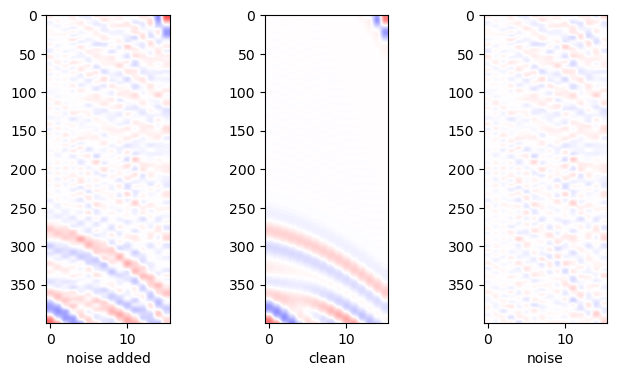

In [4]:
import matplotlib.pyplot as plt
snum = 140 #shot number
#snum = 110
#snum = 120
shot_noiseadd = data.x_train_in[snum,:,:,0]
shot_noiseadd = shot_noiseadd.transpose()

shot_clean = data.x_train_out[snum,:,:,0]
shot_clean = shot_clean.transpose()

noise = shot_noiseadd - shot_clean

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,3,1)
ax1.set_xlabel('noise added')
ax1.imshow(shot_noiseadd,aspect='0.1', cmap='seismic', vmin=-1.0, vmax=1.0)

ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel('clean')
ax2.imshow(shot_clean,aspect='0.1', cmap='seismic', vmin=-1.0, vmax=1.0)

ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel('noise')
ax3.imshow(noise,aspect='0.1', cmap='seismic', vmin=-1.0, vmax=1.0)

## 2.2 Trace 확인

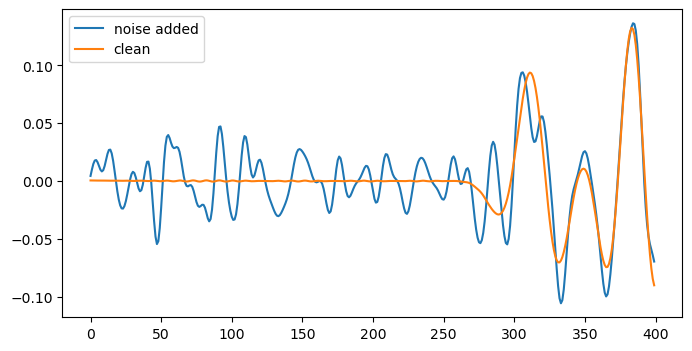

In [5]:
addn_trace = shot_noiseadd[:,8]
clean_trace = shot_clean[:,8]

fig = plt.figure(figsize=(8,4))
plt.plot(addn_trace,label='noise added')
plt.plot(clean_trace, label='clean')
plt.legend()

# 3. DnCNN 인공 신경망 구성

In [6]:
def DnCNN(depth=17,filters=64,image_channels=1, use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=(None,None,image_channels),name = 'input'+str(layer_count))
    
    # 1st layer, Conv+relu
    layer_count += 1
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',name = 'conv'+str(layer_count))(inpt)
    layer_count += 1
    x = Activation('relu',name = 'relu'+str(layer_count))(x)
    
    # depth-2 layers, Conv+BN+relu
    for i in range(depth-2):
        layer_count += 1
        x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
        if use_bnorm:
            layer_count += 1
            x = BatchNormalization(axis=3, momentum=0.9,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
        layer_count += 1
        x = Activation('relu',name = 'relu'+str(layer_count))(x)
    
    # last layer, Conv
    layer_count += 1
    x = Conv2D(filters=image_channels, kernel_size=(3,3), strides=(1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)
    layer_count += 1
    x = Subtract(name = 'subtract' + str(layer_count))([inpt, x])   # input - noise
    model = Model(inputs=inpt, outputs=x)
    return model

data.input_shape=(None,None,n_ch)
model = DnCNN(depth=depth, filters=filters, image_channels=n_ch, use_bnorm=True)
model.summary()
    

2022-12-03 15:37:34.420142: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 15:37:34.840314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input0 (InputLayer)            [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   640         ['input0[0][0]']                 
                                64)                                                               
                                                                                                  
 relu2 (Activation)             (None, None, None,   0           ['conv1[0][0]']                  
                                64)                                                           

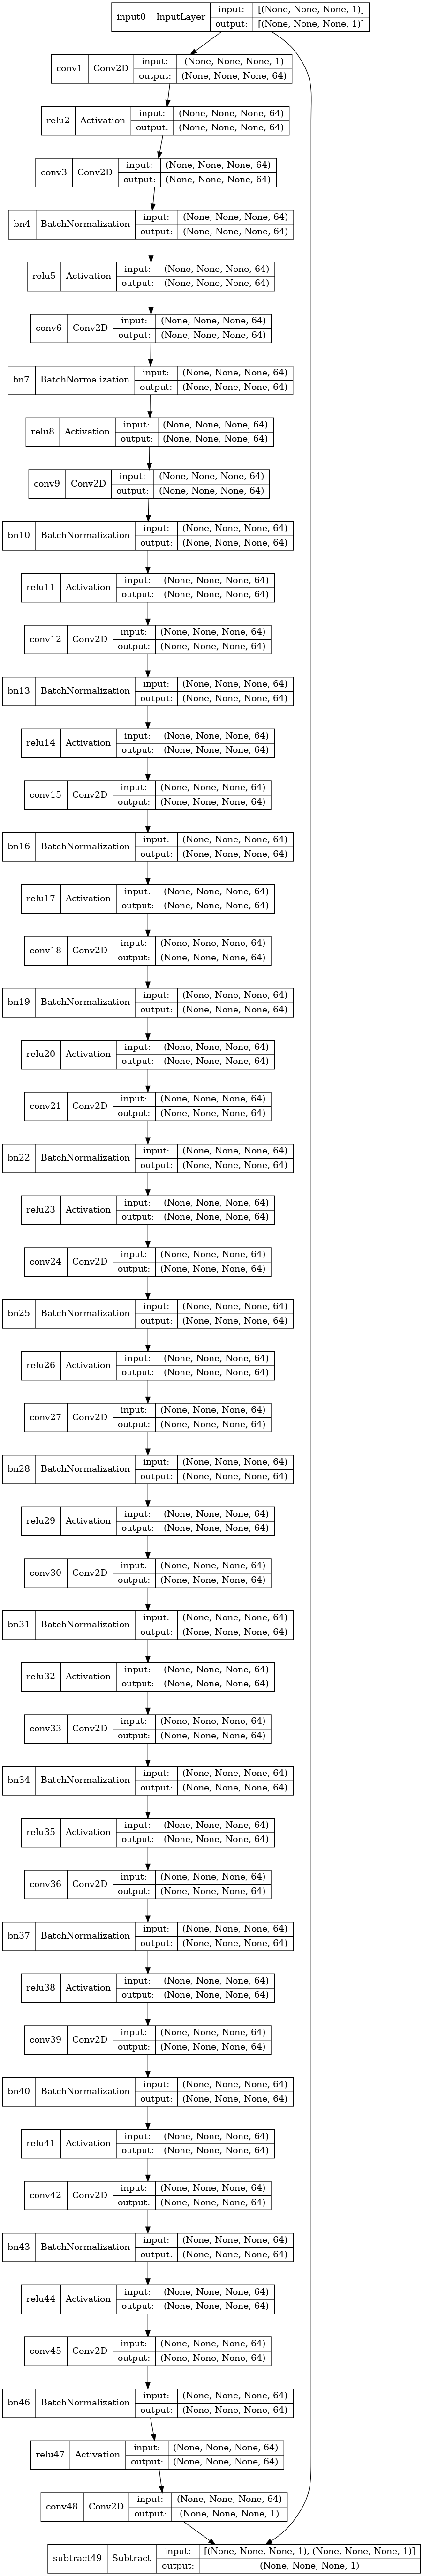

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

# 4. 학습 모델 저장 및 불러오기

In [8]:
save_dir = os.path.join('models',modeldir)
print(save_dir)
os.system("mkdir -p models")
os.system("mkdir -p %s" %save_dir)

models/model


0

In [16]:
def findLastCheckpoint(save_dir):
    file_list = glob.glob(os.path.join(save_dir,'model_*.hdf5'))  # get name list of all .hdf5 files
    if file_list:
        epochs_exist = []
        for file_ in file_list:
            result = re.findall(".*model_(.*).hdf5.*",file_)
            epochs_exist.append(int(result[0]))
        initial_epoch=max(epochs_exist)
    else:
        initial_epoch = 0
    return initial_epoch


#load the last model
initial_epoch = findLastCheckpoint(save_dir=save_dir)
if initial_epoch > epochs:
    initial_epoch = epochs
if initial_epoch > 0:
    print('resuming by loading epoch %03d' %initial_epoch)
    model = models.load_model(os.path.join(save_dir,'model_%03d.hdf5'%initial_epoch), compile=False)

#save model
checkpointer = ModelCheckpoint(os.path.join(save_dir,'model_{epoch:03d}.hdf5'),verbose=1, save_weights_only=False, period=1)
csv_logger = CSVLogger(os.path.join(save_dir,'log.csv'), append=True, separator=',')
                               

resuming by loading epoch 150


In [17]:
model.compile(optimizer=Adam(0.001), loss='MSE')

# 5. 모델 학습 수행

In [18]:
epochs=200
history = model.fit(data.x_train_in, data.x_train_out,
                    epochs=epochs,
                    initial_epoch=initial_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.2,
                    callbacks=[checkpointer,csv_logger])

Epoch 151/200
5/5 [==============================] - ETA: 0s - loss: 0.0349 
Epoch 00151: saving model to models/model/model_151.hdf5
5/5 [==============================] - 2s 178ms/step - loss: 0.0349 - val_loss: 0.0229
Epoch 152/200
5/5 [==============================] - ETA: 0s - loss: 0.0049
Epoch 00152: saving model to models/model/model_152.hdf5
5/5 [==============================] - 1s 133ms/step - loss: 0.0049 - val_loss: 0.0769
Epoch 153/200
5/5 [==============================] - ETA: 0s - loss: 0.0027
Epoch 00153: saving model to models/model/model_153.hdf5
5/5 [==============================] - 1s 135ms/step - loss: 0.0027 - val_loss: 0.1530
Epoch 154/200
5/5 [==============================] - ETA: 0s - loss: 0.0019
Epoch 00154: saving model to models/model/model_154.hdf5
5/5 [==============================] - 1s 139ms/step - loss: 0.0019 - val_loss: 0.0198
Epoch 155/200
5/5 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00155: saving model to models/model/m

5/5 [==============================] - ETA: 0s - loss: 6.5740e-04
Epoch 00187: saving model to models/model/model_187.hdf5
5/5 [==============================] - 1s 135ms/step - loss: 6.5740e-04 - val_loss: 7.8470e-04
Epoch 188/200
5/5 [==============================] - ETA: 0s - loss: 6.6387e-04
Epoch 00188: saving model to models/model/model_188.hdf5
5/5 [==============================] - 1s 136ms/step - loss: 6.6387e-04 - val_loss: 8.5455e-04
Epoch 189/200
5/5 [==============================] - ETA: 0s - loss: 6.8547e-04
Epoch 00189: saving model to models/model/model_189.hdf5
5/5 [==============================] - 1s 153ms/step - loss: 6.8547e-04 - val_loss: 7.7709e-04
Epoch 190/200
5/5 [==============================] - ETA: 0s - loss: 6.5464e-04
Epoch 00190: saving model to models/model/model_190.hdf5
5/5 [==============================] - 1s 136ms/step - loss: 6.5464e-04 - val_loss: 7.6652e-04
Epoch 191/200
5/5 [==============================] - ETA: 0s - loss: 6.3776e-04
Epoch 

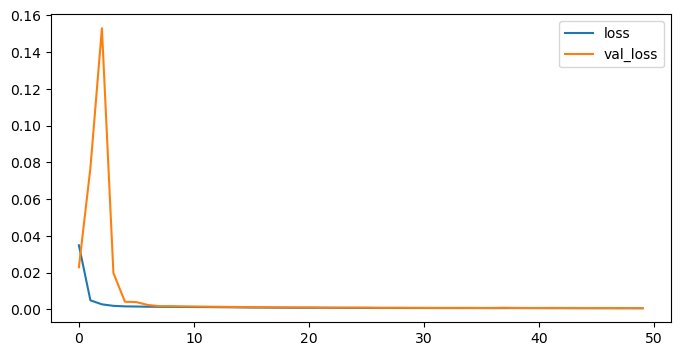

In [19]:
#print(history.history['loss'])
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

## 6. 학습된 모델을 테스트 자료에 적용 및 확인

n_test:63
(400, 16)
Prediction finished


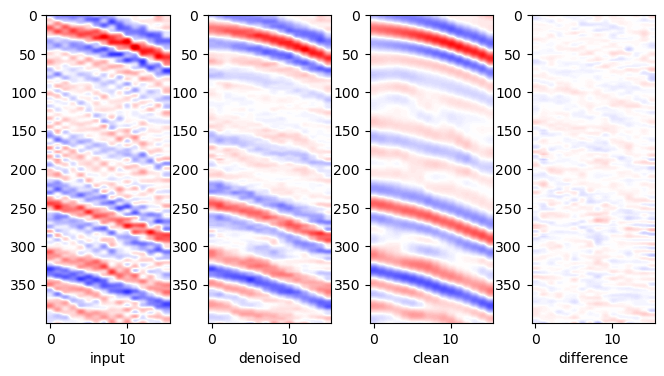

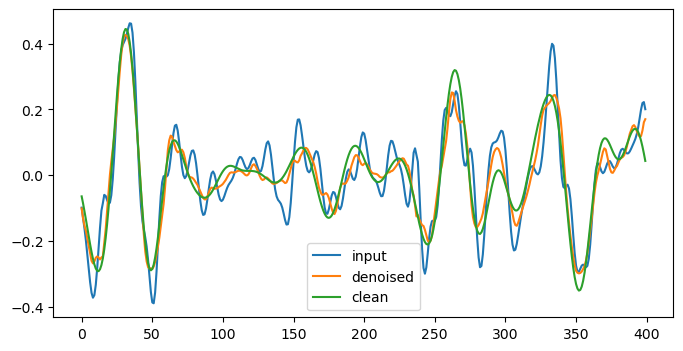

In [20]:
def predict_test(data, model):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs_org = model.predict(x_test_in)
    decoded_imgs = decoded_imgs_org
    
    print("n_test:%d"%(x_test_in.shape[0]))
    os.system("mkdir -p test_out")
    
    for jj in range(x_test_in.shape[0]):
        xxx = np.float32(x_test_in[jj,:,:,0])
        yyy = np.float32(decoded_imgs[jj,:,:,0])
        zzz = np.float32(x_test_out[jj,:,:,0])
        
        fout1 = open("./test_out/x_test_in_%06d.bin"%jj,"wb")
        fout2 = open("./test_out/x_pred_out_%06d.bin"%jj,"wb")
        fout3 = open("./test_out/x_test_out_%06d.bin"%jj,"wb")
        
        xxx.tofile(fout1)
        yyy.tofile(fout2)
        zzz.tofile(fout3)
        
        fout1.close()
        fout2.close()
        fout3.close()
        
        if jj == 15:
            fig = plt.figure(figsize=(8,4))
            
            xxx = xxx.transpose()
            print(xxx.shape)
            ax1 = fig.add_subplot(1,4,1)
            ax1.set_xlabel('input')
            ax1.imshow(xxx,aspect='0.1', cmap='seismic', vmin=-1.0, vmax=1.0)
            
            yyy = yyy.transpose()
            ax2 = fig.add_subplot(1,4,2)
            ax2.set_xlabel('denoised')
            ax2.imshow(yyy,aspect='0.1', cmap='seismic', vmin=-1.0, vmax=1.0)

            zzz = zzz.transpose()
            ax3 = fig.add_subplot(1,4,3)
            ax3.set_xlabel('clean')
            ax3.imshow(zzz,aspect='0.1', cmap='seismic', vmin=-1.0, vmax=1.0)
            
            diff = zzz-yyy
            ax4 = fig.add_subplot(1,4,4)
            ax4.set_xlabel('difference')
            ax4.imshow(diff,aspect='0.1', cmap='seismic', vmin=-1.0, vmax=1.0)


            addn_trace = xxx[:,8]
            denoise_trace = yyy[:,8]
            clean_trace = zzz[:,8]

            fig2 = plt.figure(figsize=(8,4))
            plt.plot(addn_trace, label='input')
            plt.plot(denoise_trace, label='denoised')
            plt.plot(clean_trace, label='clean')
            plt.legend()
            
predict_test(data, model)
print('Prediction finished')